# Ex 2 - Transfer learning
##### Group: X
###### Student 1: 
###### Student 2: 
###### Student 3: 

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteILHA02/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteILHA02/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

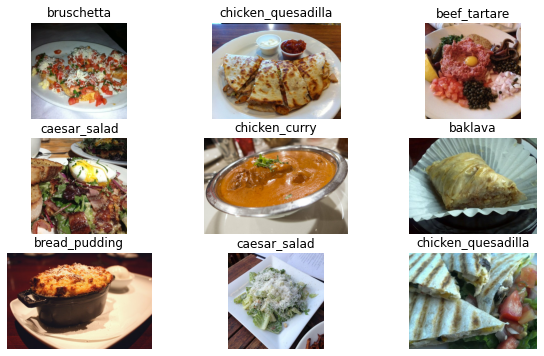

In [ ]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [4]:
# TODO Resize the images in the training, validation and test set

size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
# One hot encode the labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=N_CLASSES)))
validation_ds = validation_ds.map(lambda x, y: (x, tf.one_hot(y, depth=N_CLASSES)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=N_CLASSES)))


In [6]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

## Data-Augmentation

In [7]:
# Optional define/implements data-augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## Training
### Step 1: Only train the head of the network

In [8]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet",
)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(150, 150, 3))

x = data_augmentation(inputs)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])
x = base_model(inputs, training=False)

pool_1 = keras.layers.GlobalAveragePooling2D()(x)
drop = keras.layers.Dropout(0.2)(pool_1)  # Regularize with dropout
outputs = keras.layers.Dense(20)(drop)
model = keras.Model(inputs, outputs)

model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 2.27 s, sys: 108 ms, total: 2.38 

In [9]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# Optional: Define and use callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 10
step1_history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks = my_callbacks)


Epoch 1/10
469/469 [==============================] - 452s 941ms/step - loss: 0.2390 - binary_accuracy: 0.9400 - val_loss: 0.1801 - val_binary_accuracy: 0.9500
Epoch 2/10
469/469 [==============================] - 306s 653ms/step - loss: 0.1857 - binary_accuracy: 0.9502 - val_loss: 0.1761 - val_binary_accuracy: 0.9504
Epoch 3/10
469/469 [==============================] - 310s 660ms/step - loss: 0.1782 - binary_accuracy: 0.9505 - val_loss: 0.1743 - val_binary_accuracy: 0.9505
Epoch 4/10
469/469 [==============================] - 304s 648ms/step - loss: 0.1746 - binary_accuracy: 0.9507 - val_loss: 0.1735 - val_binary_accuracy: 0.9505
Epoch 5/10
469/469 [==============================] - 321s 685ms/step - loss: 0.1716 - binary_accuracy: 0.9508 - val_loss: 0.1737 - val_binary_accuracy: 0.9505
Epoch 6/10
469/469 [==============================] - 312s 665ms/step - loss: 0.1696 - binary_accuracy: 0.9510 - val_loss: 0.1730 - val_binary_accuracy: 0.9506
Epoch 7/10
469/469 [====================

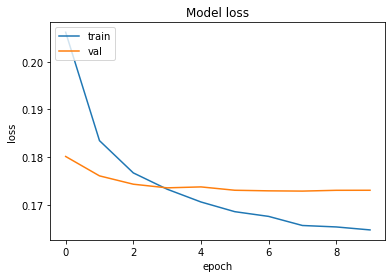

In [10]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [11]:
%%time


# Unfreeze the pretrained base. 
base_model.trainable = True

# Compile the model again
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


# Retrain the model
epochs = 10
step2_history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks = my_callbacks)


Epoch 1/10
469/469 [==============================] - 1172s 2s/step - loss: 0.3723 - binary_accuracy: 0.9349 - val_loss: 0.2272 - val_binary_accuracy: 0.9500
Epoch 2/10
469/469 [==============================] - 1176s 3s/step - loss: 0.2561 - binary_accuracy: 0.9468 - val_loss: 0.2063 - val_binary_accuracy: 0.9500
Epoch 3/10
469/469 [==============================] - 1165s 2s/step - loss: 0.2189 - binary_accuracy: 0.9499 - val_loss: 0.2022 - val_binary_accuracy: 0.9500
Epoch 4/10
469/469 [==============================] - 1199s 3s/step - loss: 0.2073 - binary_accuracy: 0.9500 - val_loss: 0.2019 - val_binary_accuracy: 0.9500
Epoch 5/10
469/469 [==============================] - 1183s 3s/step - loss: 0.2036 - binary_accuracy: 0.9500 - val_loss: 0.2018 - val_binary_accuracy: 0.9500
Epoch 6/10
469/469 [==============================] - 1178s 3s/step - loss: 0.2028 - binary_accuracy: 0.9500 - val_loss: 0.2018 - val_binary_accuracy: 0.9500
Epoch 7/10
469/469 [==============================] 

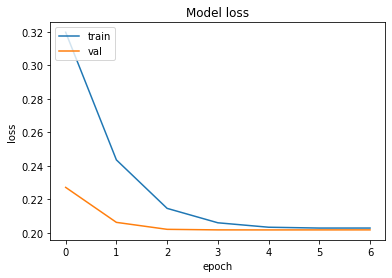

In [12]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [13]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

78/78 [==============================] - 72s 889ms/step
CPU times: user 1min 49s, sys: 9.76 s, total: 1min 59s
Wall time: 1min 12s


In [14]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.05148833467417538
CPU times: user 4.15 ms, sys: 0 ns, total: 4.15 ms
Wall time: 4.78 ms


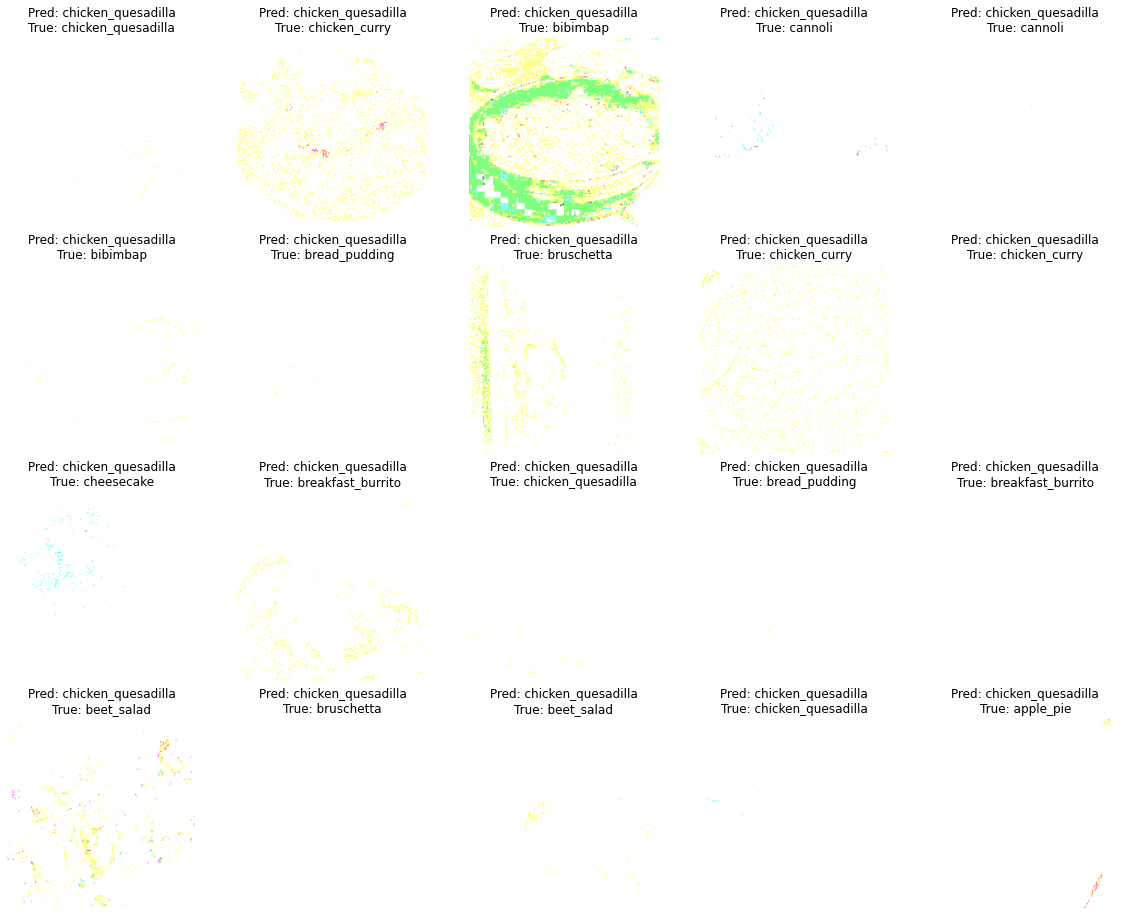

In [15]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)